# WeRateDogs Twitter Data Wrangling Project

In [1]:
import requests
import pandas as pd
import numpy as np
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import re
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

## 1.Gathering Data for this Project

### Get the Twitter Archive Document

In [2]:
twitter = pd.read_csv('twitter-archive-enhanced.csv')
twitter.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


### Downloading the Image Predictions Programmatically

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [4]:
response

<Response [200]>

In [5]:
open('image-predictions.tsv','wb').write(response.content)

335079

In [6]:
image = pd.read_csv('image-predictions.tsv', sep='\t',encoding = 'utf-8')

In [7]:
image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Getting Additional Tweets Data through API

consumer_key = 'Hidden'
consumer_secret = 'Hidden'
access_token = 'Hidden'
access_secret = 'Hidden'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = twitter.tweet_id.values
len(tweet_ids)

##### Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


In [8]:
selected_attr = []

with open('tweet_json.txt','r') as json_file:
    for line in json_file:
        json_data = json.loads(line)
        selected_attr.append({'tweet_id':json_data['id'],
                             'favorites':json_data['favorite_count'],
                             'retweets':json_data['retweet_count'],
                             'timestamp':json_data['created_at']})

retweet = pd.DataFrame(selected_attr, columns =['tweet_id','favorites','retweets','timestamp'])    

In [9]:
retweet.head()

,tweet_id,favorites,retweets,timestamp
0,892420643555336193,36498,7760,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,31451,5753,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,23694,3808,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,39815,7918,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,38011,8555,Sat Jul 29 16:00:24 +0000 2017


## 2.Assessing Data for this Project

In [10]:
twitter.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1952,673680198160809984,NaN,NaN,2015-12-07 01:47:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Shnuggles. I would kill for Shnuggles. 13/10 https://t.co/GwvpQiQ7oQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673680198160809984/photo/1,13,10,Shnuggles,None,None,None,None
1214,715200624753819648,NaN,NaN,2016-03-30 15:34:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Michelangelope. He's half coffee cup. Rare af. 12/10 would hug until someone stopped me https://t.co/tvVDY0G911,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715200624753819648/photo/1,12,10,Michelangelope,None,None,None,None
1541,689623661272240129,NaN,NaN,2016-01-20 01:41:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Lucy. She's terrified of the stuffed billed dog. 10/10 stay strong pupper https://t.co/QnvSjjyh7n,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/689623661272240129/photo/1,https://twitter.com/dog_rates/status/689623661272240129/photo/1",10,10,Lucy,None,None,pupper,None


In [11]:
twitter.info()# find if there is any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
twitter.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
twitter.rating_numerator.value_counts()# find if there is any outliner that may be errors

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [14]:
twitter.rating_denominator.value_counts()#find if there is any denominator number that is not 10

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [15]:
twitter.name.value_counts() #find if there is any missing names for Dog

None       745
a          55 
Charlie    12 
Lucy       11 
Cooper     11 
           .. 
Hazel      1  
Jimbo      1  
Jangle     1  
Diogi      1  
Mabel      1  
Name: name, Length: 957, dtype: int64

In [16]:
twitter[twitter.retweeted_status_id.notnull()].count() #find if there is any retweet that need to be deleted

tweet_id                      181
in_reply_to_status_id         0  
in_reply_to_user_id           0  
timestamp                     181
source                        181
text                          181
retweeted_status_id           181
retweeted_status_user_id      181
retweeted_status_timestamp    181
expanded_urls                 180
rating_numerator              181
rating_denominator            181
name                          181
doggo                         181
floofer                       181
pupper                        181
puppo                         181
dtype: int64

In [17]:
twitter[twitter.tweet_id.duplicated()]# find if there is any duplicated IDs

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [18]:
image.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
114,667924896115245057,https://pbs.twimg.com/media/CUTyJpHWcAATl0O.jpg,1,Labrador_retriever,0.209051,True,hog,0.203980,False,Newfoundland,0.165914,True
207,669942763794931712,https://pbs.twimg.com/media/CUwdYL5UsAAP0XX.jpg,1,vizsla,0.743216,True,redbone,0.217282,True,Rhodesian_ridgeback,0.028473,True
1688,815390420867969024,https://pbs.twimg.com/media/C1DZQiTXgAUqgRI.jpg,1,restaurant,0.279846,False,toyshop,0.091429,False,paper_towel,0.046147,False


In [19]:
image.info()# find if there is any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [21]:
image.jpg_url.duplicated().sum()# find if there is any duplicated urls which will be retweet

66

In [22]:
retweet.sample(3)

,tweet_id,favorites,retweets,timestamp
1490,691090071332753408,1723,337,Sun Jan 24 02:48:07 +0000 2016
2170,668872652652679168,511,290,Mon Nov 23 19:24:02 +0000 2015
248,843235543001513987,21557,6017,Sat Mar 18 22:59:54 +0000 2017


In [23]:
retweet.info()# find if there is any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
tweet_id     2331 non-null int64
favorites    2331 non-null int64
retweets     2331 non-null int64
timestamp    2331 non-null object
dtypes: int64(3), object(1)
memory usage: 73.0+ KB


In [24]:
retweet[retweet.tweet_id.duplicated()]# find if there is any duplicated IDs

,tweet_id,favorites,retweets,timestamp


#### Quality  
##### `twitter` **table**
- There are some retweets that need to be deleted
- There are some tweets that are missing expanded_urls that need to be deleted
- Missing information in some columns(all irrelevant to this project, can drop)
- Max rating_numerator may have error 
- rating_denominator is not 10 where it should be 10  
- Missing dog names( **too many senarios to be concidered,cannot clean**)
- Timestamp dtype should be Datetime

##### `image` **table**
- There are some duplicated urls that need to be deleted

#### Tidiness
##### `twitter` **table**
- Dog Stages should be in one columns  
- All three tables can be merged into one table

## 3.Cleaning Data for this project

In [25]:
#creating copies of above tables for clearning
twitter_clean = twitter.copy()
image_clean = image.copy()
retweet_clean = retweet.copy()

###  Quality 

#### `twitter` **table** : 

##### Define: 
find all the retweets and drop them in twitter table, there should be all the rows that is not  null in retweeted_status_id column

##### Code:

In [26]:
twitter_clean = twitter_clean[twitter_clean.retweeted_status_id.isnull()]

##### Test:

In [27]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

##### Define: 
find all the tweets that do not have images provided, there should be all the rows that has values in expanded_urls column.

##### Code:

In [28]:
twitter_clean = twitter_clean[twitter_clean.expanded_urls.notnull()]

##### Test:

In [29]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null object
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
dtypes: float64(4), int64(3), object(1

##### Define: 
Drop all the irrelevant columns in twitter table:in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp

##### Code:

In [30]:
twitter_clean = twitter_clean.drop(['in_reply_to_status_id',
                    'in_reply_to_user_id',
                    'retweeted_status_id',
                    'retweeted_status_user_id',
                    'retweeted_status_timestamp'], axis =1)

##### Test:

In [31]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2117 non-null int64
timestamp             2117 non-null object
source                2117 non-null object
text                  2117 non-null object
expanded_urls         2117 non-null object
rating_numerator      2117 non-null int64
rating_denominator    2117 non-null int64
name                  2117 non-null object
doggo                 2117 non-null object
floofer               2117 non-null object
pupper                2117 non-null object
puppo                 2117 non-null object
dtypes: int64(3), object(9)
memory usage: 215.0+ KB


##### Define: 
The Max rating_numerator is too large that may be an error, I will find out this data by extract actual rating in text column and confirm if this is true.

##### Code:

In [32]:
twitter_clean.rating_numerator.sort_values(ascending = False)

979     1776
2074    420 
1120    204 
902     165 
1779    144 
       ...  
2335    1   
2338    1   
2091    1   
1016    0   
315     0   
Name: rating_numerator, Length: 2117, dtype: int64

In [33]:
new_rate = twitter_clean.text.str.extract('(\d+)\/(\d+)')

In [34]:
new_rate.columns = ['rating_numerator','rating_denominator']

In [35]:
twitter_clean['rating_numerator'] = new_rate['rating_numerator'].astype('int64')
twitter_clean['rating_denominator'] = new_rate['rating_denominator'].astype('int64')

In [36]:
twitter_clean.rating_numerator.sort_values(ascending=False)

979     1776
2074    420 
1120    204 
902     165 
1779    144 
       ...  
2335    1   
2338    1   
2091    1   
1016    0   
315     0   
Name: rating_numerator, Length: 2117, dtype: int64

##### Test:

In [37]:
twitter_clean.loc[979]
# This is confirm to be correc that the rating_numerator is 1776, this dog must be really popular.

tweet_id              749981277374128128                                                                 
timestamp             2016-07-04 15:00:45 +0000                                                          
source                <a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>
text                  This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh     
expanded_urls         https://twitter.com/dog_rates/status/749981277374128128/photo/1                    
rating_numerator      1776                                                                               
rating_denominator    10                                                                                 
name                  Atticus                                                                            
doggo                 None                                                                               
floofer               None                    

##### Define: 
Find all the rows that rating_denominator is not 10, find out the reason and try to make all of the denominator as 10

##### Code:

In [38]:
#Using the latest rating_denominator that was extracted from text column to make it more accurate
twitter_clean.rating_denominator.value_counts().sort_index(ascending = False)

170    1   
150    1   
130    1   
120    1   
110    1   
90     1   
80     2   
70     1   
50     3   
40     1   
20     1   
11     2   
10     2099
7      1   
2      1   
Name: rating_denominator, dtype: int64

In [39]:
sum(twitter_clean.rating_denominator !=10) #find total number of rating_denominator that is not 10

18

In [40]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2117 non-null int64
timestamp             2117 non-null object
source                2117 non-null object
text                  2117 non-null object
expanded_urls         2117 non-null object
rating_numerator      2117 non-null int64
rating_denominator    2117 non-null int64
name                  2117 non-null object
doggo                 2117 non-null object
floofer               2117 non-null object
pupper                2117 non-null object
puppo                 2117 non-null object
dtypes: int64(3), object(9)
memory usage: 295.0+ KB


In [41]:
twitter_clean[twitter_clean.rating_denominator !=10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
902,758467244762497024,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1120,731156023742988288,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184652801,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,None,None,None,None
1228,713900603437621249,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,None,None,None,None
1254,710658690886586372,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80,80,None,None,None,None,None
1274,709198395643068416,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",https://twitter.com/dog_rates/status/709198395643068416/photo/1,45,50,None,None,None,None,None


###### After a manual review on text columns and the rating there,it turns out some ratings are for a group of dogs which is not relevant to our project.  These rows need to be dropped.
- Part 1: rows to be droped:433,516(No Rating),902,1120,1228,1254,1274,1351,1433,1634,1635,1779,1843,1165
- Part 2: rows to be fixed:1068,1202,1662,2335 on both rating_numerator and rating_denominator


In [42]:
twitter_clean = twitter_clean.drop([433,516,902,1120,1228,1254,1274,1351,1433,1634,1635,1779,1843,1165])

In [43]:
twitter_clean[twitter_clean.rating_denominator !=10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1202,716439118184652801,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,None,None,None,None
1662,682962037429899265,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/dog_rates/status/682962037429899265/photo/1,7,11,Darrel,None,None,None,None
2335,666287406224695296,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,an,None,None,None,None


In [44]:
twitter_clean.replace({'rating_denominator':{11:10,50:10,2:10}},inplace = True)#Replace all the values to 10

##### Test:

In [45]:
twitter_clean[twitter_clean.rating_denominator !=10].count()# Now all the Rating_denominator is 10

tweet_id              0
timestamp             0
source                0
text                  0
expanded_urls         0
rating_numerator      0
rating_denominator    0
name                  0
doggo                 0
floofer               0
pupper                0
puppo                 0
dtype: int64

In [46]:
twitter_clean.rating_denominator.value_counts()

10    2103
Name: rating_denominator, dtype: int64

##### Code: Part 2 `rows to be fixed:1068,1202,1662,2335` on rating_numerator

In [47]:
twitter_clean.loc[1068,'rating_numerator']=14

In [48]:
twitter_clean.loc[1202,'rating_numerator']=11

In [49]:
twitter_clean.loc[1662,'rating_numerator']=10

In [50]:
twitter_clean.loc[2335,'rating_numerator']=9

##### Test: Part 2

In [51]:
twitter_clean.loc[[1068,1202,1662,2335]] #Both rating_numerator and rating_denominator are fixed manually

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",14,10,None,None,None,None,None
1202,716439118184652801,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,11,10,Bluebert,None,None,None,None
1662,682962037429899265,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/dog_rates/status/682962037429899265/photo/1,10,10,Darrel,None,None,None,None
2335,666287406224695296,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,9,10,an,None,None,None,None


##### Define: 
Timestamp dtype is string which should be datetime

##### Code:

In [52]:
twitter_clean['timestamp'] = pd.to_datetime(twitter_clean.timestamp)

##### Test:

In [53]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2103 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2103 non-null int64
timestamp             2103 non-null datetime64[ns, UTC]
source                2103 non-null object
text                  2103 non-null object
expanded_urls         2103 non-null object
rating_numerator      2103 non-null int64
rating_denominator    2103 non-null int64
name                  2103 non-null object
doggo                 2103 non-null object
floofer               2103 non-null object
pupper                2103 non-null object
puppo                 2103 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(8)
memory usage: 293.6+ KB


##### `image` **table**

##### Define: 
There are some duplicated urls in image table that need to be deleted as they are retweet

##### Code:

In [54]:
image_clean.jpg_url.drop_duplicates(inplace = True)

##### Test:

In [55]:
image_clean.jpg_url.duplicated().sum()

0

### Tidiness

##### Define: 
Dog Stages should be in one column

##### Code:

In [56]:
#creating a new column called stage that contain the finding text for those dog stages
twitter_clean['stage'] = twitter_clean.text.str.findall('(doggo|floofer|pupper|puppo)')
twitter_clean['stage'] = twitter_clean['stage'].apply(lambda x: ''.join(set(x)))

In [57]:
#replace the missing values to np.nan
twitter_clean['stage'] = twitter_clean['stage'].replace('',np.nan)

In [58]:
# we can see that there are 10 records that have double stages for a dog.
twitter_clean['stage'].value_counts()

pupper         234
doggo          74 
puppo          27 
doggopupper    8  
floofer        4  
puppodoggo     2  
Name: stage, dtype: int64

In [59]:
#remove those addition columns
twitter_clean.drop(twitter_clean[['doggo','puppo','pupper','floofer']],axis=1,inplace=True)

##### Test:

In [60]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2103 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2103 non-null int64
timestamp             2103 non-null datetime64[ns, UTC]
source                2103 non-null object
text                  2103 non-null object
expanded_urls         2103 non-null object
rating_numerator      2103 non-null int64
rating_denominator    2103 non-null int64
name                  2103 non-null object
stage                 349 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(5)
memory usage: 244.3+ KB


##### Define: 
Merge all three tables into one

##### Code:

In [61]:
df_clean = twitter_clean.merge(image_clean,how='inner',on='tweet_id').merge(retweet_clean,how='inner',on='tweet_id')

##### Test:

In [62]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1973 entries, 0 to 1972
Data columns (total 23 columns):
tweet_id              1973 non-null int64
timestamp_x           1973 non-null datetime64[ns, UTC]
source                1973 non-null object
text                  1973 non-null object
expanded_urls         1973 non-null object
rating_numerator      1973 non-null int64
rating_denominator    1973 non-null int64
name                  1973 non-null object
stage                 317 non-null object
jpg_url               1973 non-null object
img_num               1973 non-null int64
p1                    1973 non-null object
p1_conf               1973 non-null float64
p1_dog                1973 non-null bool
p2                    1973 non-null object
p2_conf               1973 non-null float64
p2_dog                1973 non-null bool
p3                    1973 non-null object
p3_conf               1973 non-null float64
p3_dog                1973 non-null bool
favorites             1973 n

## 4.Storing Data for this project

In [63]:
df_clean.to_csv('twitter_archive_master.csv', index = False)

## 5.Analyzing and Visualizing Data for this project

In [64]:
#creating a copy for Analyzing purpose
analyze = df_clean.copy()
analyze.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1973 entries, 0 to 1972
Data columns (total 23 columns):
tweet_id              1973 non-null int64
timestamp_x           1973 non-null datetime64[ns, UTC]
source                1973 non-null object
text                  1973 non-null object
expanded_urls         1973 non-null object
rating_numerator      1973 non-null int64
rating_denominator    1973 non-null int64
name                  1973 non-null object
stage                 317 non-null object
jpg_url               1973 non-null object
img_num               1973 non-null int64
p1                    1973 non-null object
p1_conf               1973 non-null float64
p1_dog                1973 non-null bool
p2                    1973 non-null object
p2_conf               1973 non-null float64
p2_dog                1973 non-null bool
p3                    1973 non-null object
p3_conf               1973 non-null float64
p3_dog                1973 non-null bool
favorites             1973 n

###### Insight Questions:
1. What's the top 5 tweets that has most favorities?
2. What are the top 5 breeds of dogs that people tweet about?
3. Is there any relationship between dog's rating and tweet's favorites?

###### 1.What's the top 5 tweets that has most favorities?

In [65]:
favorites = analyze.sort_values(by = 'favorites',ascending = False).head()

In [66]:
#This is the total number of favorites for the top five tweets
favorites.favorites

766    157726
305    134380
394    121738
107    117329
801    116424
Name: favorites, dtype: int64

In [67]:
#getting images for the top 5 favorite dogs and use it to show.
favorites.jpg_url

766    https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg
305    https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg                                        
394    https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg
107    https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg                                        
801    https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg
Name: jpg_url, dtype: object

![image of top](https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg)
![image of top](https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg)
![image of top](https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg)
![image of top](https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg)                                        
![image of top](https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg)

###### 2.What are the top 5 breeds of dogs that people tweet about?

In [68]:
# define a dataframe that contains all the cloumns we need
df_breeds = analyze[['p1','p1_dog','p2','p2_dog','p3','p3_dog','favorites']]

In [69]:
#create a list that has all the breed varieties
varieties = []
for i in df_breeds.index:
    if df_breeds.p1_dog.loc[i]==True:
        varieties.append(df_breeds.p1.loc[i])
    elif df_breeds.p2_dog.loc[i]==True:
        varieties.append(df_breeds.p2.loc[i])
    elif df_breeds.p3_dog.loc[i]==True:
        varieties.append(df_breeds.p3.loc[i])
    else:
        varieties.append(np.nan)

In [70]:
#Add newly created list onto df_breeds dataframe
df_breeds['variety'] = varieties

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
#check outcome
df_breeds.head()

,p1,p1_dog,p2,p2_dog,p3,p3_dog,favorites,variety
0,orange,False,bagel,False,banana,False,36498,NaN
1,Chihuahua,True,Pekinese,True,papillon,True,31451,Chihuahua
2,Chihuahua,True,malamute,True,kelpie,True,23694,Chihuahua
3,paper_towel,False,Labrador_retriever,True,spatula,False,39815,Labrador_retriever
4,basset,True,English_springer,True,German_short-haired_pointer,True,38011,basset


In [72]:
#drop all the NaN Values that are not inline with predition condition
df_breeds = df_breeds[df_breeds.variety.notnull()]

In [73]:
#get the top 5 list of breeds with total favorites received
breeds = df_breeds.groupby('variety')['favorites'].sum().sort_values(ascending=False).head(5)

In [74]:
breeds = breeds.reset_index()

In [75]:
breeds

,variety,favorites
0,golden_retriever,1813581
1,Labrador_retriever,1129511
2,Pembroke,978484
3,Chihuahua,726830
4,French_bulldog,566382


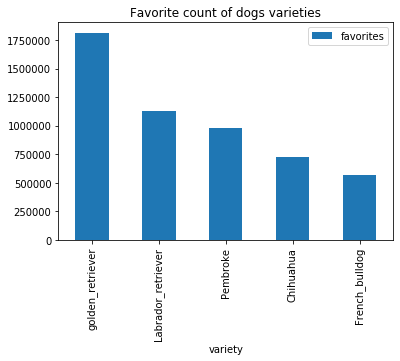

In [76]:
breeds.plot.bar(x='variety',y='favorites')
plt.title('Favorite count of dogs varieties');

we can see that the top 5 favorite breeds are golden_retriever,Labrador_retriever,pembroke,chihuahua and French_bulldog

###### 3.Is there any relationship between dog's rating and tweet's favorites?

In [77]:
relationship = analyze[['rating_numerator','favorites']]

In [78]:
relationship.rating_numerator.value_counts()

12      448
10      419
11      397
13      257
9       151
8       95 
7       51 
14      36 
5       33 
6       32 
3       19 
4       15 
2       9  
1       4  
0       2  
420     1  
26      1  
27      1  
75      1  
1776    1  
Name: rating_numerator, dtype: int64

In [79]:
#since there are some outliner that can affect plot outcome and most of ratings are within 20,I set this plot limit as 20.
relationship = relationship[relationship.rating_numerator<20]

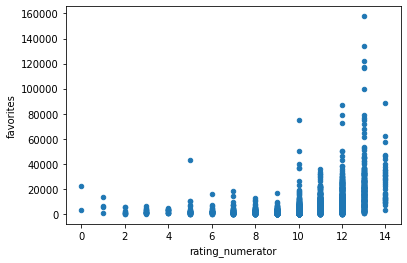

In [80]:
relationship.plot.scatter(x='rating_numerator', y='favorites');

Base on the scatter plot above, we can see that there is a positive relationship between dog ratings and favorites. 
In general the more favorites that tweet get, the higher ratings dog will get. 
It is also interesting to point out that there are some ratings are well above average.